In [ ]:
# Import libraries
from google.colab import drive
import os
import time
import numpy as np
import pandas as pd
import pickle
import math
from scipy import interp
from itertools import cycle
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import load_model
from keras.utils import np_utils
import urllib.request
import cv2

In [ ]:
# Connect with Google Drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
def load_data(path, filename):
  '''
  Loads data from a pickle file.

  Parameters
  ----------
  data: numpy array
  path : string
      Path to folder containing the data.
  filename : string
      Name the file to be saved under.
      
  Returns
  -------
  data : numpy array
  '''

  with open(path + filename, 'rb') as output:
    data = pickle.load(output)

  return data

In [ ]:
def get_prediction(image, model, class_names):
  '''
  Predicts image class.
  
  Parameters
  ----------
  image : image object
  model : deep learning model
      
  Returns
  -------
  class_names : list
    Predicted class.
  '''

  image = np.expand_dims(image, axis=0)
  
  prediction = model.predict(image)

  predicted_class = np.argmax(prediction)
  
  return class_names[predicted_class]

In [ ]:
def url_to_image(url):
  '''
  Reads image from url and performs preprocessing.
   
  Parameters
  ----------
  url: string
      Url to image.
      
  Returns
  -------
  image_resized: image
    Preprocessed image.
  image : image
    Original image.
  '''

  resp = urllib.request.urlopen(url)
  image = np.asarray(bytearray(resp.read()), dtype="uint8")

  image = cv2.imdecode(image, cv2.IMREAD_COLOR)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  image_resized  = cv2.resize(image, (224,224))
  image_resized = image_resized/255.0

  return image_resized, image 

In [ ]:
def predict_url(url, model, class_names):
  '''
  Shows image and predicted class.
  
  Parameters
  ----------
  url: string
      Url to image.
  model : deep learning model
  class_names : list
  

  Returns
  -------
  None

  '''
  image_resized, image = url_to_image(url)
  predicted_class = get_prediction(image_resized, model, class_names)
  plt.imshow(image_resized)

  plt.title("Predicted label : " + predicted_class)

In [ ]:
class_names = ['indoor selfie', 'outdoor selfie', 'indoor pose', 'outdoor pose', 'no human']

# Load test data

In [ ]:
X_test = load_data('/content/drive/My Drive/DataScience/Test Data/', 'dataset_test.pickle')
y_test = load_data('/content/drive/My Drive/DataScience/Test Data/', 'labels_test.pickle')

# Preprocessing

In [ ]:
# Check datatype and value range
print(X_test.dtype)
print(np.max(X_test))
print(np.min(X_test))

float32
255.0
0.0


In [ ]:
# Normalize the dataset:
X_test = X_test/255.0

In [ ]:
# Save original labels
y_test1 = y_test

In [ ]:
# One hot encode outputs
y_test = y_test.reshape(-1,1)
y_test.shape

y_test = np_utils.to_categorical(y_test)

num_classes = y_test.shape[1]

# Model load

In [ ]:
model = load_model('/content/drive/My Drive/DataScience/Models/best_model_mobile.pt')

# Model predict

In [ ]:
# Get probabilities
pred = model.predict(X_test)

# Get predicted class
predictions = []
for i in range(y_test1.shape[0]):
  predictions.append(np.argmax(pred[i]))

# Benchmark

In [ ]:
# import time

# average = []
# for i in range(20):
  
#   begin = time.time()
#   predict_url('https://pbs.twimg.com/media/BhxWutnCEAAtEQ6?format=jpg&name=large', model, class_names)
#   end = time.time()
#   print(f"{end-begin} seconds")
#   print(f"{1/(end-begin)} FPS")
#   average.append(1/(end-begin))

# print("AVERAGE BENCHMARK")
# print(np.mean(average), "FPS")

## Accuracy

In [ ]:
# Accuracy
accuracy_score(y_test1, predictions)

1.0

## Confusion matrix


Confusion matrix 



Text(0.5, 1.0, 'Confusion Matrix')

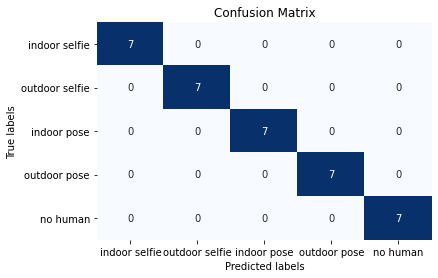

In [ ]:
print('Confusion matrix \n')
cm = confusion_matrix(y_test1, predictions)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)

ax= plt.subplot()
sns.heatmap(df_cm, cmap='Blues', annot=True, cbar =False, fmt='g')

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

## Precision/Recall


In [ ]:
print('Classification report \n')
print(classification_report(y_test1, predictions, target_names = class_names))

Classification report 

                precision    recall  f1-score   support

 indoor selfie       1.00      1.00      1.00         7
outdoor selfie       1.00      1.00      1.00         7
   indoor pose       1.00      1.00      1.00         7
  outdoor pose       1.00      1.00      1.00         7
      no human       1.00      1.00      1.00         7

      accuracy                           1.00        35
     macro avg       1.00      1.00      1.00        35
  weighted avg       1.00      1.00      1.00        35



## Roc curves

In [ ]:
# Calculate ROC AUC Score
n_classes = y_test.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

lw =2
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


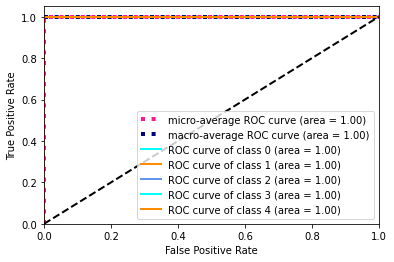

In [ ]:
# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)
plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

## Hardware

Average prediction time 1.3956995010375977


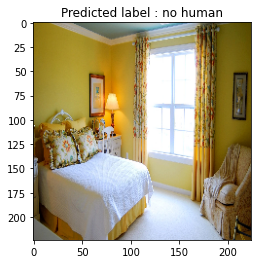

In [ ]:
t = []
for i in range(10):
  start = time.time()
  predict_url('https://interior777.com/wallpapers/big/interior_design_0stil-interer-komnata0_image_big_1920x1080.jpg', model, class_names)
  end = time.time()
  t.append(end-start)

print("Average prediction time", sum(t) / len(t))

## Image from url

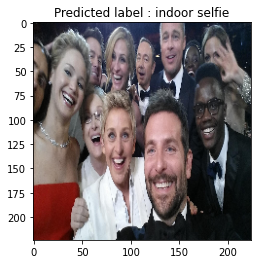

In [ ]:
predict_url('https://pbs.twimg.com/media/BhxWutnCEAAtEQ6?format=jpg&name=large', model, class_names)

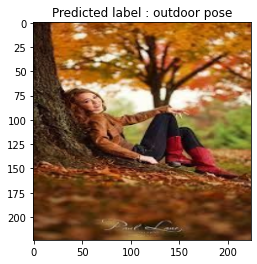

In [ ]:
predict_url("https://i.pinimg.com/564x/75/a1/10/75a11040555ec21814ef12dec0d722c8.jpg", model, class_names)

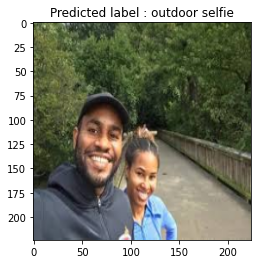

In [ ]:
predict_url('https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcT_Lmku2Gdil4qtKhtR_WQAZC4Tt61skT0PPw&usqp=CAU', model, class_names)

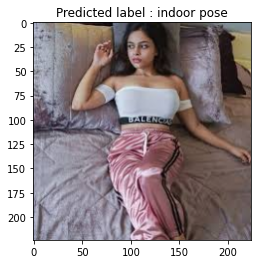

In [ ]:
predict_url('https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSngIvIJvbGHrmur-AxElUWgCIDIU-TR2L5Dw&usqp=CAU', model, class_names)

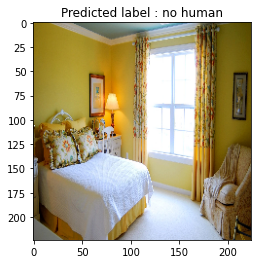

In [ ]:
predict_url('https://interior777.com/wallpapers/big/interior_design_0stil-interer-komnata0_image_big_1920x1080.jpg', model, class_names)

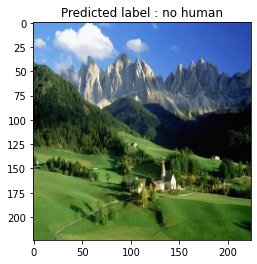

In [ ]:
  predict_url('https://im0-tub-com.yandex.net/i?id=97e4669207e711b9adcc586a15ecea0d&n=13', model, class_names)